# SympNetsTorch Example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import symplectic_koopman_operator.symplectic_koopman_operator as sko
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import SympNetsTorch.SympNets as snn

%matplotlib widget

# Global Parameters

In [2]:
# Pytorch settings variables
random_seed = None  # Set to None to use random seed

# speeds up training, but might cause problems do not change unless you get errors
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

# Use 64 bit precision for inverse
torch.set_default_dtype(torch.float64)

# Use GPU if available
if random_seed is not None:
    torch.manual_seed(random_seed)
if torch.cuda.is_available():
    device = "cuda:0"
    torch.set_default_device(device)
else:
    device = "cpu"

# Check if cuda is being used
if torch.zeros(1).is_cuda:
    print("Cuda is working!")

Cuda is working!


# Set Up Variables

In [ ]:
def func(x: torch.Tensor) -> torch.Tensor:
    """The function defining the system dynamics."""
    return torch.stack((3 * x[..., 0] ** 2 - x[..., 0] * x[..., 1], x[..., 1]), dim=-1)

In [ ]:
# Split info
test_size = 0.25
random_state = None

# Prep
numdata = 50
numfeatures = 2

data_amplitude = 1.0

# Create data
x = torch.linspace(-data_amplitude, data_amplitude, numdata)
y = torch.linspace(-data_amplitude, data_amplitude, numdata)
x, y = torch.meshgrid(x, y, indexing="ij")  # Create a meshgrid for 2D input
x = x.flatten()
y = y.flatten()

input_data = torch.stack((x, y), dim=1)
output_data = func(input_data)  # Apply the function to get output data

train_x, test_x, train_y, test_y = train_test_split(
    input_data, output_data, test_size=test_size, random_state=random_state
)

## Classes

In [5]:
class network_model_example(nn.Module):
    def __init__(self, features: int, ncoder: int) -> None:
        super().__init__()

        # Putting models in a list to loop through and adjust them.
        self.layers = nn.ModuleList(
            [
                snn.Linear(features, "up", n=ncoder),
                snn.Activation(torch.relu, features, "up"),
                snn.Linear(features, "low", n=ncoder),
                snn.Activation(torch.relu, features, "low"),
                snn.Linear(features, "up", n=ncoder),
            ]
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # The function that is called when the model is being trained / tested
        for layer in self.layers:
            x = layer(x)

        return x

## Training and Test Functions

In [6]:
def train_model(model, optimizer, epochs, train_loader, batch_size):
    train_losses = []
    train_counter = []

    # set network to training mode
    model.train()

    # iterate through data batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # reset gradients
        optimizer.zero_grad()

        # evaluate network with data
        output = model(data)

        # compute loss and derivative
        loss = F.mse_loss(output, target)  # Can implement a custom loss function here

        loss.backward()

        # step optimizer
        optimizer.step()

        # print out results and save to file
        train_losses.append(loss.item() / len(train_loader.dataset))
        train_counter.append(
            (batch_idx * batch_size) + ((epochs - 1) * len(train_loader.dataset))
        )

    return train_losses, train_counter


def test_model(model, test_loader):
    test_losses = []

    model.eval()

    test_loss = 0

    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)

            test_loss = F.mse_loss(output, target).item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    return test_losses

# Training Frequency Model

In [7]:
# Training info
n_epochs = 150  # number of epochs to train for
learning_rate = 1e-3
betas = (0.9, 0.999)  # Default
batch_size = 100

# Network Objects
nn_model = network_model_example(numfeatures // 2, 8)

optimizer = optim.Adam(
    nn_model.parameters(),
    lr=learning_rate,
    betas=betas,
)

train_data = torch.utils.data.TensorDataset(train_x, train_y)
test_data = torch.utils.data.TensorDataset(test_x, test_y)

train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    generator=torch.Generator(device=device),
)
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=True,
    generator=torch.Generator(device=device),
)

# Train the _bin model
train_losses = []
test_losses = []
train_count = []

for epoch in range(1, n_epochs + 1):
    temp = train_model(nn_model, optimizer, epoch, train_loader, batch_size)

    train_losses += temp[0]
    train_count += temp[1]

    test_losses += test_model(nn_model, test_loader)

nn_model.eval()

network_model_example(
  (layers): ModuleList(
    (0): Linear(
      (layers): ModuleList(
        (0): linear_sub_up()
        (1): linear_sub_low()
        (2): linear_sub_up()
        (3): linear_sub_low()
        (4): linear_sub_up()
        (5): linear_sub_low()
        (6): linear_sub_up()
        (7): linear_sub_low()
      )
    )
    (1): Activation(
      (layer): activation_sub_up()
    )
    (2): Linear(
      (layers): ModuleList(
        (0): linear_sub_low()
        (1): linear_sub_up()
        (2): linear_sub_low()
        (3): linear_sub_up()
        (4): linear_sub_low()
        (5): linear_sub_up()
        (6): linear_sub_low()
        (7): linear_sub_up()
      )
    )
    (3): Activation(
      (layer): activation_sub_low()
    )
    (4): Linear(
      (layers): ModuleList(
        (0): linear_sub_up()
        (1): linear_sub_low()
        (2): linear_sub_up()
        (3): linear_sub_low()
        (4): linear_sub_up()
        (5): linear_sub_low()
        (6): lin

## Plotting Results

Min Loss: 8.54e-01



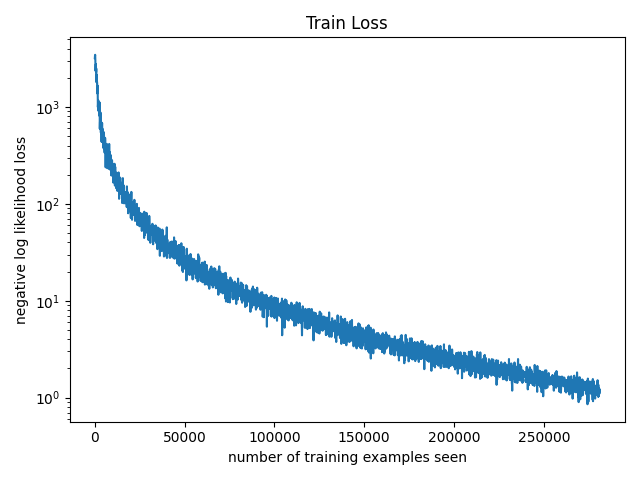

In [8]:
fig, ax = plt.subplots()
ax.plot(train_count, train_losses)
ax.set_title(f"Train Loss")
ax.set_xlabel("number of training examples seen")
ax.set_ylabel("negative log likelihood loss")
ax.set_yscale("log")
fig.tight_layout()
fig.savefig("train-loss.png", dpi=300)
print(f"Min Loss: {np.min(train_losses):.2e}\n")

Min Loss: 2.41e+00



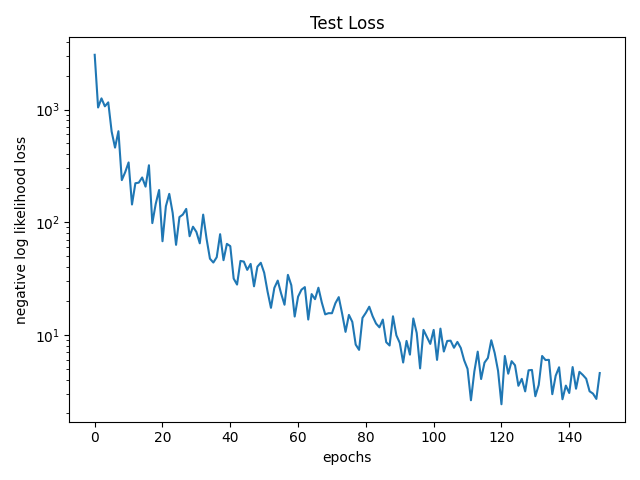

In [9]:
fig, ax = plt.subplots()
ax.plot(test_losses)
ax.set_title("Test Loss")
ax.set_xlabel("epochs")
ax.set_ylabel("negative log likelihood loss")
ax.set_yscale("log")
fig.tight_layout()
fig.savefig("test-loss.png", dpi=300)
print(f"Min Loss: {np.min(test_losses):.2e}\n")

## Save Model

In [10]:
model_file_name = "model-state-dict.pt"
# torch.save(nn_model.state_dict(), model_file_name)

In [11]:
# Load model
# nn_model.load_state_dict(torch.load(model_file_name))
# nn_model.eval()

torch.Size([625, 2])
torch.Size([625, 2])


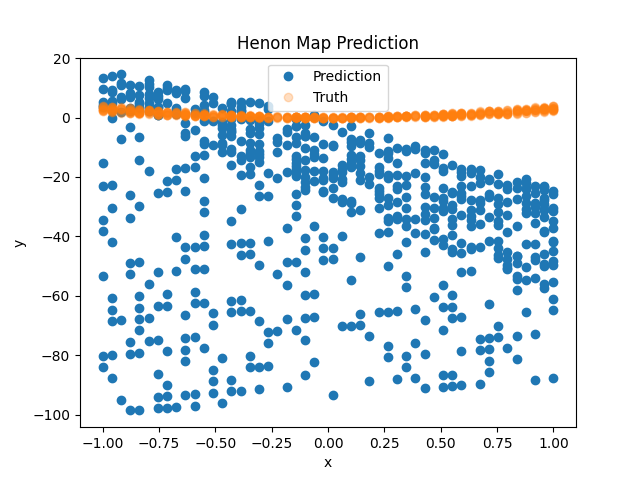

In [12]:
fig, ax = plt.subplots()

y_truth = func(test_x)
y_pred = nn_model(test_x)

print(y_pred.shape)
print(y_truth.shape)

ax.plot(
    test_x[:, 0].cpu().numpy(),
    y_pred[:, 0].detach().cpu().numpy(),
    "o",
    label="Prediction",
)
ax.plot(
    test_x[:, 0].cpu().numpy(),
    y_truth[:, 0].detach().cpu().numpy(),
    "o",
    label="Truth",
    alpha=0.25,
)

ax.set_title("Henon Map Prediction")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()